# 2 Sample Tests Power over Increasing Dimension

In [24]:
import sys, os

from joblib import Parallel, delayed
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from hyppo.independence import MGC, Dcorr, Hsic, HHG, CCA, RV
from power_2samp import power_ksamp
sys.path.append(os.path.realpath('..'))

In [25]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import pairwise_distances
from scipy.stats.distributions import chi2

from hyppo.independence.base import IndependenceTest
from hyppo.independence.dcorr import _dcorr
from hyppo.independence._utils import sim_matrix
from hyppo.ksample import k_sample_transform


FOREST_TYPES = {
    "classifier" : RandomForestClassifier,
    "regressor" : RandomForestRegressor
}


class KMERF(IndependenceTest):
    r"""
    Class for calculating the random forest based Dcorr test statistic and p-value.
    """

    def __init__(self, forest="classifier", ntrees=500, **kwargs):
        if forest in FOREST_TYPES.keys():
            self.clf = FOREST_TYPES[forest](n_estimators=ntrees, **kwargs)
        else:
            raise ValueError("forest must be one of the following ")
        IndependenceTest.__init__(self)

    def statistic(self, x, y):
        r"""
        Helper function that calculates the random forest based Dcorr test statistic.
        """
        rf_y = y
        if y.shape[1] == 1:
            rf_y = y.ravel()
        self.clf.fit(x, rf_y)
        self.first_time = False
        distx = np.sqrt(1 - sim_matrix(self.clf, x))
        if x.shape[1] == y.shape[1]:
            disty = np.sqrt(1 - sim_matrix(self.clf, y))
        else:
            disty = pairwise_distances(
                y, metric="euclidean"
            )
        stat = _dcorr(distx, disty, bias=False, is_fast=False)

        return stat
    
    def test(self, x, y):
        n = x.shape[0]
        u, v = k_sample_transform([x, y], test_type="rf")
        stat = self.statistic(u, v)
        us = k_sample_transform([u, u], test_type="rf")
        vs = k_sample_transform([v, v], test_type="rf")
        statx = self.statistic(*us)
        staty = self.statistic(*vs)
        pvalue = chi2.sf(stat / np.sqrt(statx * staty) * n + 1, 1)
        return stat, pvalue

In [26]:
from typing import NamedTuple

import numpy as np
from scipy.stats import entropy

from honest_forests import HonestForestClassifier  # change this to scikit-tree later
from hyppo.independence._utils import _CheckInputs
from hyppo.independence.base import IndependenceTest


class MIRFTestOutput(NamedTuple):
    stat: float
    pvalue: float
    # mirf_dict: dict


class MIRF(IndependenceTest):
    r"""
    Independence test using mutual information as the test statistic.

    Parameters
    ----------
    n_estimators : int, default: 100
        The number of trees in the forest.
    honest_fraction : float, default=0.5
        Fraction of training samples used for estimates in the trees. The
        remaining samples will be used to learn the tree structure. A larger
        fraction creates shallower trees with lower variance estimates.
    honest_prior : {"ignore", "uniform", "empirical"}, default="empirical"
        Method for dealing with empty leaves during evaluation of a test
        sample. If "ignore", the tree is ignored. If "uniform", the prior tree
        posterior is 1/(number of classes). If "empirical", the prior tree
        posterior is the relative class frequency in the voting subsample.
        If all trees are ignored, the empirical estimate is returned.
    **kwargs
        Additional arguments used for the forest (see
        :class:`honest_forests.HonestForestClassifier`)
    """

    def __init__(
        self, n_estimators=500, honest_fraction=0.5, honest_prior="empirical", **kwargs
    ):
        self.clf = HonestForestClassifier(
            n_estimators=n_estimators,
            honest_fraction=honest_fraction,
            honest_prior=honest_prior,
            **kwargs
        )
        IndependenceTest.__init__(self)

    def statistic(self, x, y):
        r"""
        Helper function that calculates the MI test statistic.

        Parameters
        ----------
        x,y : ndarray of float
            Input data matrices. ``x`` and ``y`` must have the same number of
            samples. That is, the shapes must be ``(n, p)`` and ``(n, 1)`` where
            `n` is the number of samples and `p` is the number of
            dimensions.

        Returns
        -------
        stat : float
            The computed MI statistic.
        """
        self.clf.fit(x, y.ravel())
        H_YX = np.mean(entropy(self.clf.predict_proba(x), base=np.exp(1), axis=1))
        _, counts = np.unique(y, return_counts=True)
        H_Y = entropy(counts, base=np.exp(1))
        stat = max(H_Y - H_YX, 0)
        self.stat = stat

        return stat

    def test(self, x, y, reps=1000, workers=1, random_state=None):
        r"""
        Calculates the MI test statistic and p-value.

        Parameters
        ----------
        x,y : ndarray of float
            Input data matrices. ``x`` and ``y`` must have the same number of
            samples. That is, the shapes must be ``(n, p)`` and ``(n, 1)`` where
            `n` is the number of samples and `p` is the number of
            dimensions.
        reps : int, default: 1000
            The number of replications used to estimate the null distribution
            when using the permutation test used to calculate the p-value.
        workers : int, default: 1
            The number of cores to parallelize the p-value computation over.
            Supply ``-1`` to use all cores available to the Process.

        Returns
        -------
        stat : float
            The computed MI statistic.
        pvalue : float
            The computed MI p-value.

        Examples
        --------
        >>> import numpy as np
        >>> from hyppo.independence import MI
        >>> x = np.arange(100)
        >>> y = x
        >>> '%.1f, %.2f' % MI().test(x, y)[:1] # doctest: +SKIP
        '1.0, 0.001'
        """
        check_input = _CheckInputs(x, y, reps=reps)
        x, y = check_input()

        stat, pvalue = super(MIRF, self).test(
            x, y, reps, workers, is_distsim=False, random_state=random_state
        )
        # mirf_dict = {}

        return MIRFTestOutput(stat, pvalue)  # , mirf_dict)

In [27]:
sns.set(color_codes=True, style='white', context='talk', font_scale=1.5)
PALETTE = sns.color_palette("Set1")
sns.set_palette(PALETTE[1:5] + PALETTE[6:], n_colors=10)

MAX_DIMENSION = 10
STEP_SIZE = 1
DIMENSIONS = range(3, MAX_DIMENSION + STEP_SIZE, STEP_SIZE)
POWER_REPS = 5
REPS = 10000

SIMULATIONS = {
    "linear": "Linear",
    "exponential": "Exponential",
    "cubic": "Cubic",
    "joint_normal": "Joint Normal",
    "step": "Step",
    "quadratic": "Quadratic",
    "w_shaped": "W-Shaped",
    "spiral": "Spiral",
    "uncorrelated_bernoulli": "Bernoulli",
    "logarithmic": "Logarithmic",
    "fourth_root": "Fourth Root",
    "sin_four_pi": "Sine 4\u03C0",
    "sin_sixteen_pi": "Sine 16\u03C0",
    "square": "Square",
    "two_parabolas": "Two Parabolas",
    "circle": "Circle",
    "ellipse": "Ellipse",
    "diamond": "Diamond",
    "multiplicative_noise": "Multiplicative",
    "multimodal_independence": "Independence"
}

TESTS = [
     KMERF,
     MGC,
     Dcorr,
     Hsic,
      HHG,
     CCA,
     RV,
    MIRF
]

In [28]:
RENAME_TESTS = {
    "Dcorr": "Energy",
    "Hsic": "MMD"
}

def estimate_power(sim, test):
    est_power = np.array([power_ksamp(test, sim, n=100, p=dim, noise=False, reps=REPS)
                          for dim in DIMENSIONS])
    if test.__name__ in ["Dcorr", "Hsic"]:
        np.savetxt('/home/azureuser/hyppo-papers-2/output_reproduce/{}_{}.csv'.format(sim, RENAME_TESTS[test.__name__]),
               est_power, delimiter=',')
    else:
        np.savetxt('/home/azureuser/hyppo-papers-2/output_reproduce/10000_{}_{}.csv'.format(sim, test.__name__),
                   est_power, delimiter=',')
    
    return est_power

In [29]:
# Uncomment the code below to reproduce power results.
# Note, this takes a very long time to run. Highly recommend using a virtual machine to reproduce.
outputs = Parallel(n_jobs=-1, verbose=100)(
    [delayed(estimate_power)(sim, test) for sim in SIMULATIONS.keys() for test in TESTS]
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 93.3min
[Parallel(n_jobs=-1)]: Done   2 out of  20 | elapsed: 93.3min remaining: 839.4min
[Parallel(n_jobs=-1)]: Done   3 out of  20 | elapsed: 93.3min remaining: 528.5min
[Parallel(n_jobs=-1)]: Done   4 out of  20 | elapsed: 93.3min remaining: 373.1min
[Parallel(n_jobs=-1)]: Done   5 out of  20 | elapsed: 93.3min remaining: 279.8min
[Parallel(n_jobs=-1)]: Done   6 out of  20 | elapsed: 93.3min remaining: 217.6min
[Parallel(n_jobs=-1)]: Done   7 out of  20 | elapsed: 93.3min remaining: 173.2min
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed: 93.3min remaining: 139.9min
[Parallel(n_jobs=-1)]: Done   9 out of  20 | elapsed: 93.3min remaining: 114.0min
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed: 93.3min remaining: 93.3min
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed: 93.3min remaining: 76.3min
[Parallel(n_jobs=-1)]: Done  12 out of  20 

KeyboardInterrupt: 

In [21]:
def plot_power():
    fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(25,20))
    
    plt.suptitle("Multivariate Two-Sample Testing (Increasing Dimension)", y=0.93, va='baseline')
    
    for i, row in enumerate(ax):
        for j, col in enumerate(row):
            count = 5*i + j
            sim = list(SIMULATIONS.keys())[count]
            
            for test in TESTS[::-1]:
                test_name = test.__name__
                if test_name == "Dcorr":
                    test_name = "Energy"
                elif test_name == "Hsic":
                    test_name = "MMD"
                
                if test_name == "MIRF":
                    power = np.genfromtxt('/home/azureuser/hyppo-papers-2/output_reproduce/{}_{}.csv'.format(sim, test_name), delimiter=',')
                    col.plot(DIMENSIONS, power, color="#e41a1c", label=test_name, lw=4)
                else:
                    power = np.genfromtxt('/home/azureuser/hyppo-papers-2/kmerf/2samp_vs_dimension/{}_{}.csv'.format(sim, test_name), delimiter=',')
                    col.plot(DIMENSIONS, power, label=test_name, lw=2)
                col.set_xticks([DIMENSIONS[0], DIMENSIONS[-1]])
                col.set_ylim(-0.05, 1.05)
                col.set_yticks([])
                if j == 0:
                    col.set_yticks([0, 1])
                col.set_title(SIMULATIONS[sim])
    
    fig.text(0.5, 0.07, 'Dimension', ha='center')
    fig.text(0.07, 0.5, 'Statistical Power', va='center', rotation='vertical')
    leg = plt.legend(bbox_to_anchor=(0.5, 0.07), bbox_transform=plt.gcf().transFigure,
                     ncol=len(TESTS), loc='upper center', reverse=True)
    leg.get_frame().set_linewidth(0.0)
    for legobj in leg.legend_handles:
        legobj.set_linewidth(5.0)
    plt.subplots_adjust(hspace=.50)
    #plt.savefig('/home/azureuser/hyppo-papers-2/output_reproduce/2samp_power_dimension_4method.pdf', transparent=True, bbox_inches='tight')

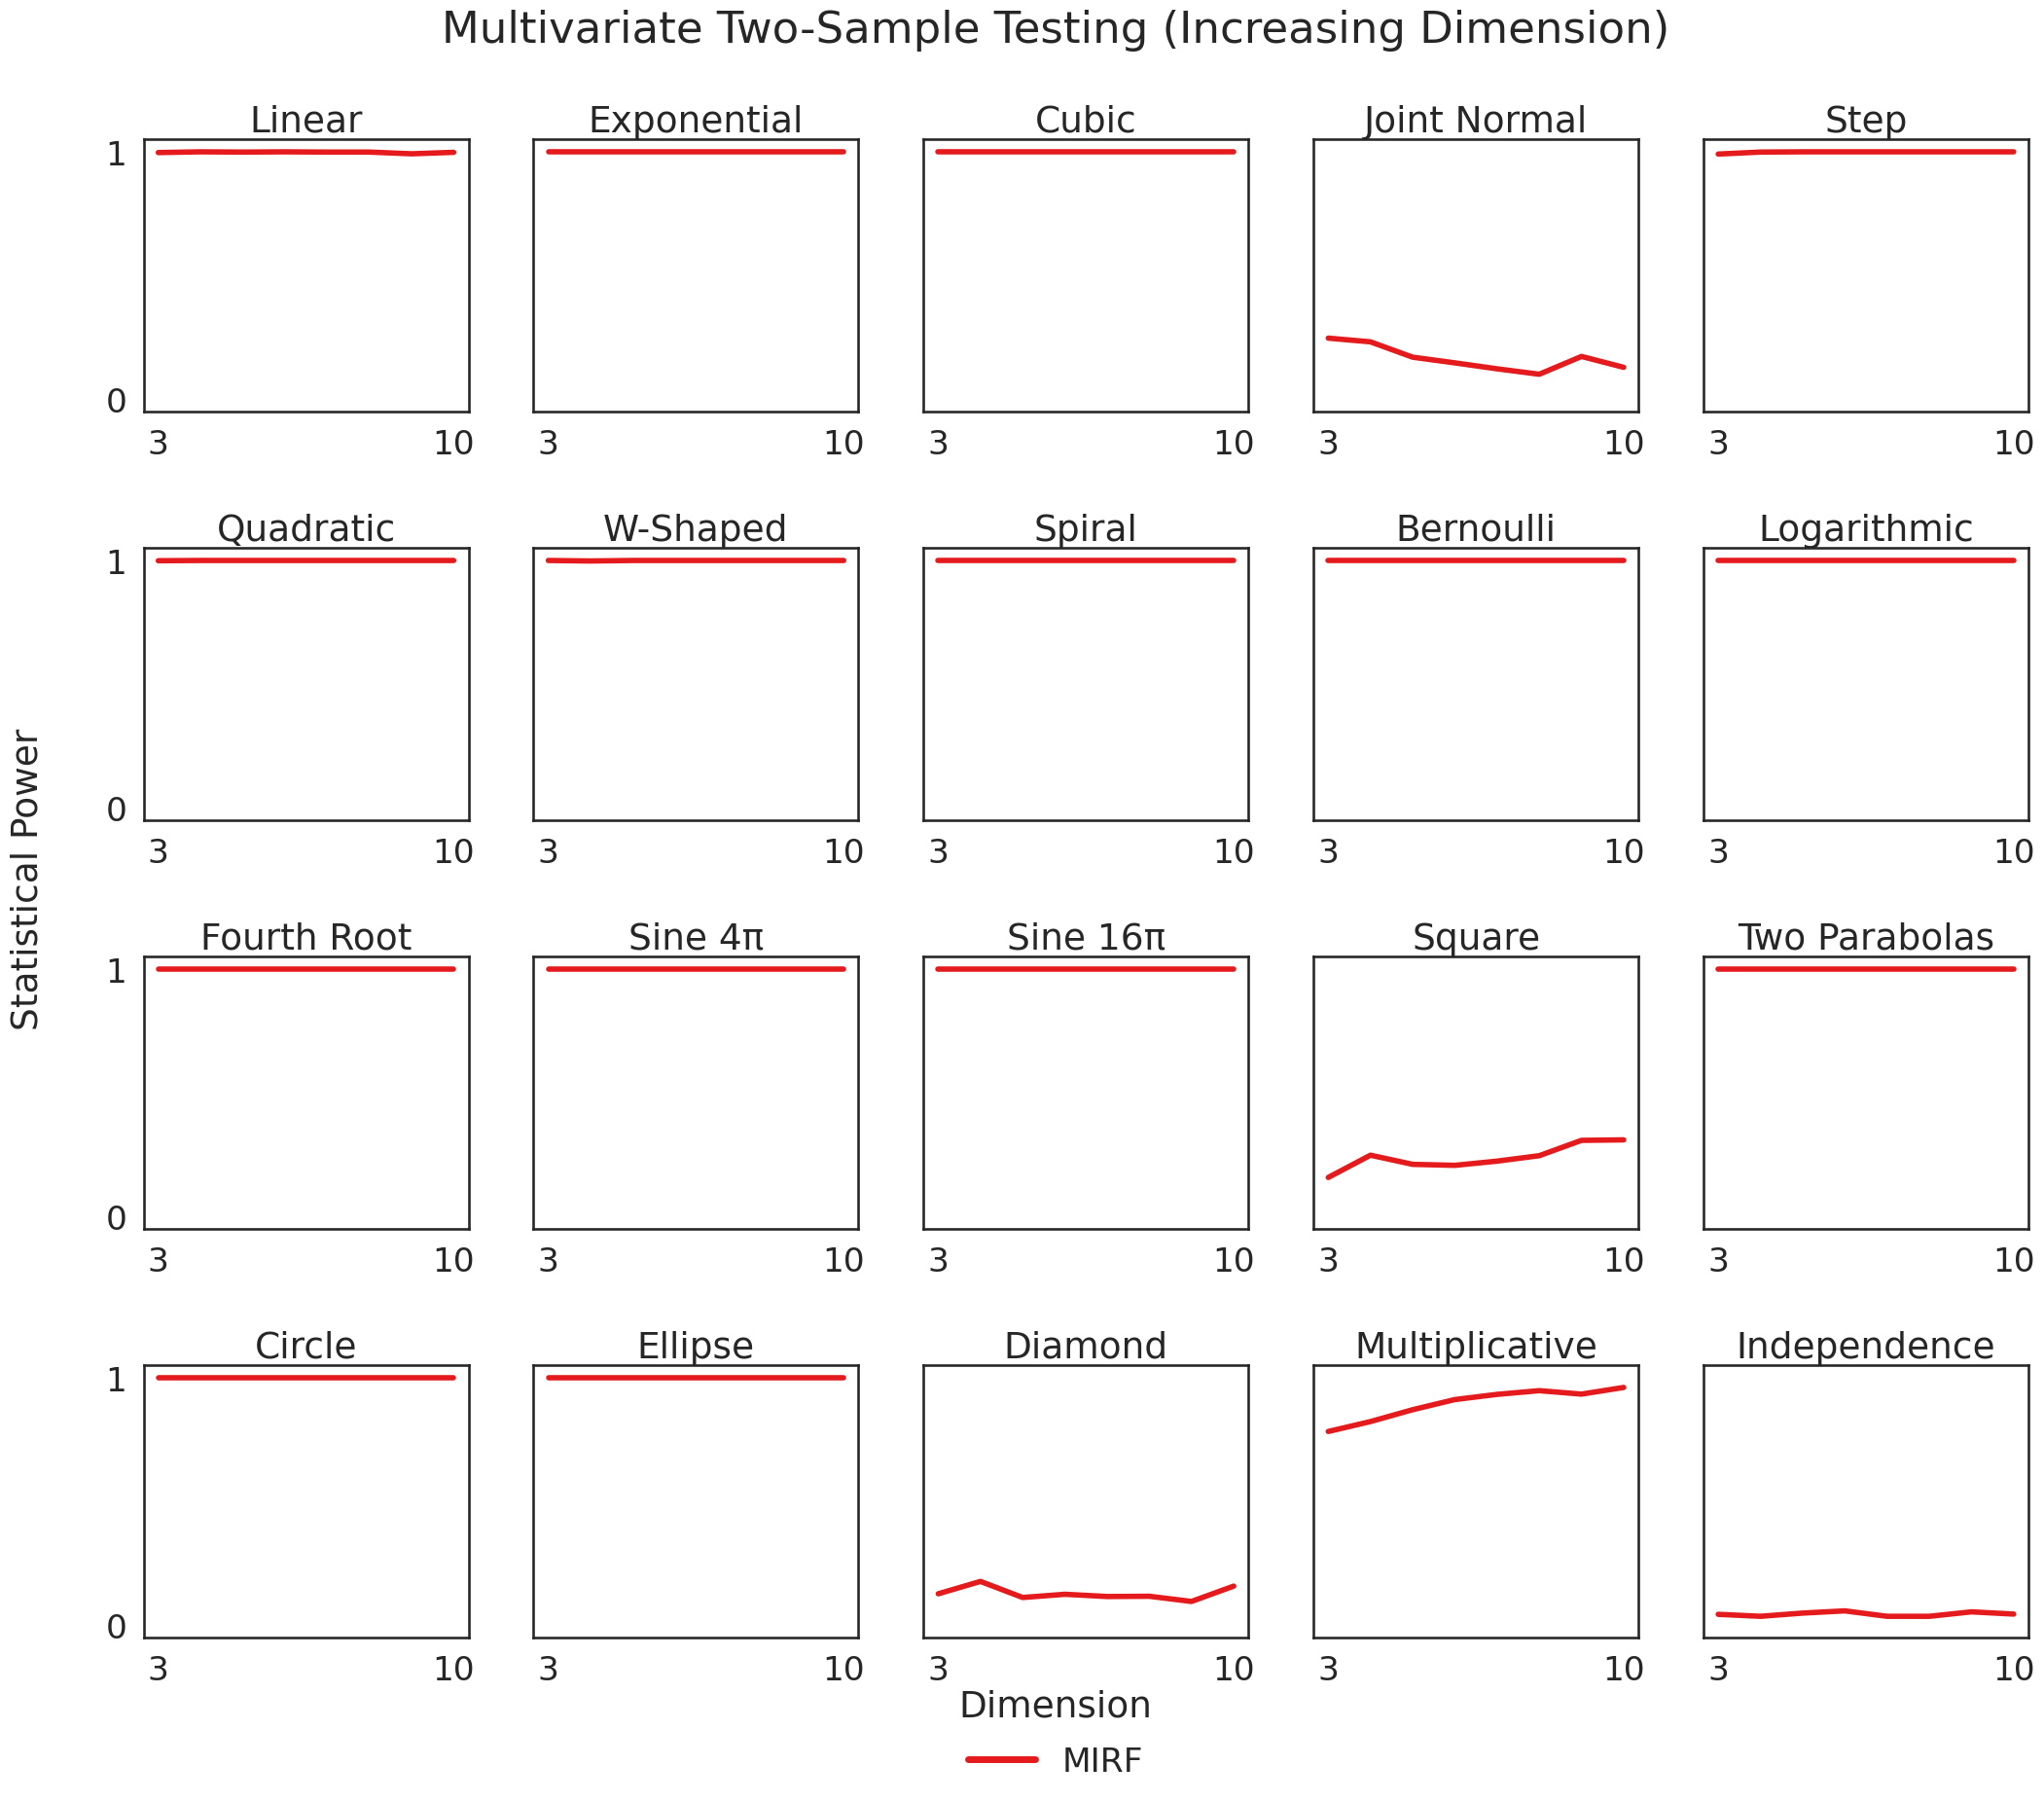

In [22]:
plot_power()

In [31]:
def plot_power():
    fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(25,20))
    
    plt.suptitle("Multivariate Two-Sample Testing (Increasing Dimension)", y=0.93, va='baseline')
    
    for i, row in enumerate(ax):
        for j, col in enumerate(row):
            count = 5*i + j
            sim = list(SIMULATIONS.keys())[count]
            
            for test in TESTS[::-1]:
                test_name = test.__name__
                if test_name == "Dcorr":
                    test_name = "Energy"
                elif test_name == "Hsic":
                    test_name = "MMD"
                
                if test_name == "MIRF":
                    power = np.genfromtxt('/home/azureuser/hyppo-papers-2/output_reproduce/{}_{}.csv'.format(sim, test_name), delimiter=',')
                    col.plot(DIMENSIONS, power, color="#e41a1c", label=test_name, lw=4)
                elif test_name == "KMERF":
                    power = np.genfromtxt('/home/azureuser/hyppo-papers-2/kmerf/2samp_vs_dimension/{}_{}.csv'.format(sim, test_name), delimiter=',')
                    col.plot(DIMENSIONS, power, color="#e41a1c", label=test_name, lw=4,linestyle='dashed')
                else:
                    power = np.genfromtxt('/home/azureuser/hyppo-papers-2/kmerf/2samp_vs_dimension/{}_{}.csv'.format(sim, test_name), delimiter=',')
                    col.plot(DIMENSIONS, power, label=test_name, lw=2)
                col.set_xticks([DIMENSIONS[0], DIMENSIONS[-1]])
                col.set_ylim(-0.05, 1.05)
                col.set_yticks([])
                if j == 0:
                    col.set_yticks([0, 1])
                col.set_title(SIMULATIONS[sim])
    
    fig.text(0.5, 0.07, 'Dimension', ha='center')
    fig.text(0.07, 0.5, 'Statistical Power', va='center', rotation='vertical')
    leg = plt.legend(bbox_to_anchor=(0.5, 0.07), bbox_transform=plt.gcf().transFigure,
                     ncol=len(TESTS), loc='upper center', reverse=True)
    leg.get_frame().set_linewidth(0.0)
    for legobj in leg.legend_handles:
        legobj.set_linewidth(5.0)
    plt.subplots_adjust(hspace=.50)
    #plt.savefig('/home/azureuser/hyppo-papers-2/output_reproduce/2samp_power_dimension_4method.pdf', transparent=True, bbox_inches='tight')

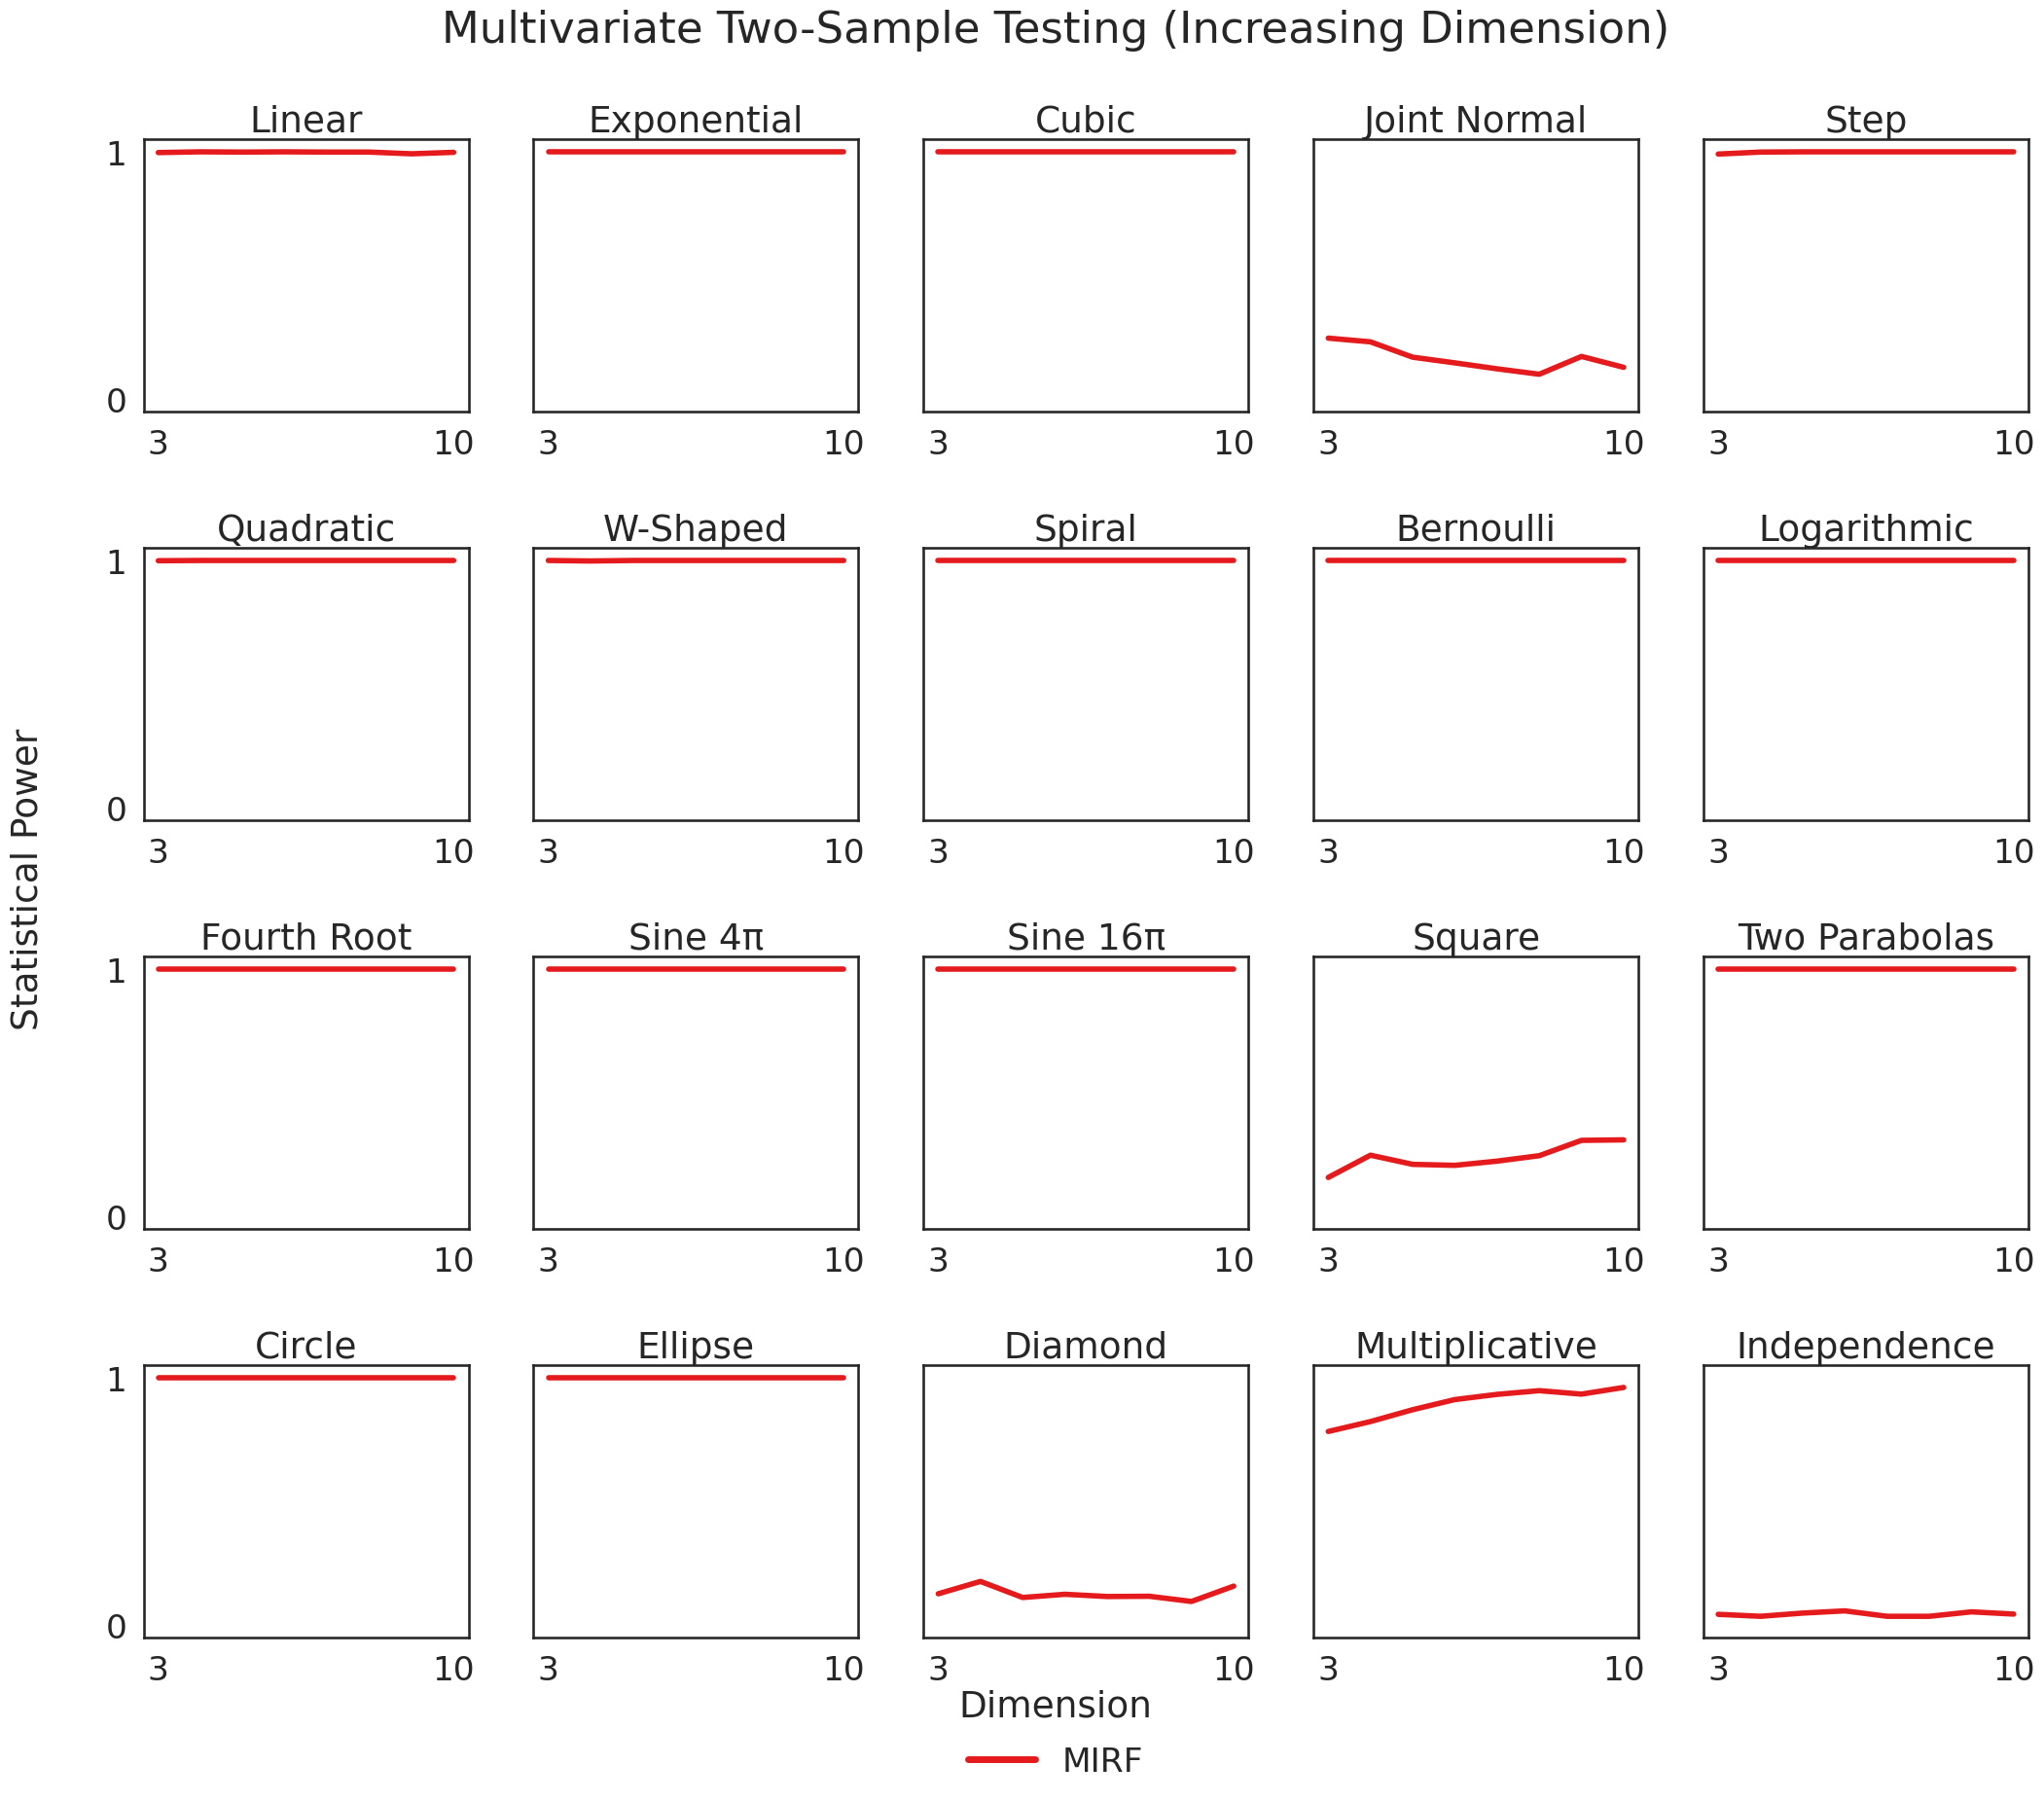

In [32]:
plot_power()

In [17]:
def plot_power_origin():
    fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(25,20))
    
    plt.suptitle("Multivariate Two-Sample Testing (Increasing Dimension)", y=0.93, va='baseline')
    
    for i, row in enumerate(ax):
        for j, col in enumerate(row):
            count = 5*i + j
            sim = list(SIMULATIONS.keys())[count]
            
            for test in TESTS[::-1]:
                test_name = test.__name__
                if test_name == "Dcorr":
                    test_name = "Energy"
                elif test_name == "Hsic":
                    test_name = "MMD"
                power = np.genfromtxt('/home/azureuser/hyppo-papers-2/output_reproduce/{}_{}.csv'.format(sim, test_name), delimiter=',')

                if test_name == "KMERF":
                    col.plot(DIMENSIONS, power, color="#e41a1c", label=test_name, lw=4)
                else:
                    col.plot(DIMENSIONS, power, label=test_name, lw=2)
                col.set_xticks([DIMENSIONS[0], DIMENSIONS[-1]])
                col.set_ylim(-0.05, 1.05)
                col.set_yticks([])
                if j == 0:
                    col.set_yticks([0, 1])
                col.set_title(SIMULATIONS[sim])
    
    fig.text(0.5, 0.07, 'Dimension', ha='center')
    fig.text(0.07, 0.5, 'Statistical Power', va='center', rotation='vertical')
    leg = plt.legend(bbox_to_anchor=(0.5, 0.07), bbox_transform=plt.gcf().transFigure,
                     ncol=len(TESTS), loc='upper center', reverse=True)
    leg.get_frame().set_linewidth(0.0)
    for legobj in leg.legend_handles:
        legobj.set_linewidth(5.0)
    plt.subplots_adjust(hspace=.50)
    plt.savefig('/home/azureuser/hyppo-papers-2/output_reproduce/2samp_power_dimension_4method.pdf', transparent=True, bbox_inches='tight')